# Sierra Leone Solar Data: EDA, Profiling & Cleaning
Date: November 11, 2025  
Author: Elias Wakgari 
Objective: Profile, clean, and explore Sierra Leone's solar dataset for insights.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats  # For Z-scores
import warnings
import os  # For path checks
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8')  # Or 'default' if seaborn-v0_8 not available
sns.set_palette("husl")

# Hard absolute path from your terminal listing (Windows-friendly)
file_path = r'C:\Users\Y\solar-challenge-week1\data\sierraleone-bumbuna.csv'  # r'' for raw string, ignores \

print(f"🔍 Notebook cwd: {os.getcwd()}")  # Will show notebooks/—confirms the issue!
print(f"📄 Full file path: {file_path}")
print(f"✅ File exists? {os.path.exists(file_path)}")

# Load with absolute path & error handling
try:
    df = pd.read_csv(file_path, parse_dates=['Timestamp'])  # Swap 'Timestamp' if col differs
    print("✅ File loaded successfully!")
except FileNotFoundError:
    print("❌ Path wrong—verify in Explorer: C:\\Users\\Y\\solar-challenge-week1\\data\\sierraleone-bumbuna.csv")
    raise
except ValueError as e:
    if "Unable to parse" in str(e):
        print("⚠️ Timestamp col issue—run quick peek below to check cols.")
        # Quick peek without parse_dates
        df_peek = pd.read_csv(file_path)
        print("Columns:", df_peek.columns.tolist())
        print("First row sample:", df_peek.iloc[0].to_dict())
    raise

# If loaded, set index
if 'df' in locals():  # Check if load succeeded
    df.set_index('Timestamp', inplace=True)  # Index by time for TS analysis
    print(f"Dataset shape: {df.shape}")
    print(df.head())
    print(df.dtypes)

🔍 Notebook cwd: C:\Users\Y\solar-challenge-week1\notebooks
📄 Full file path: C:\Users\Y\solar-challenge-week1\data\sierraleone-bumbuna.csv
✅ File exists? True


✅ File loaded successfully!
Dataset shape: (525600, 18)
                     GHI  DNI  DHI  ModA  ModB  Tamb    RH   WS  WSgust  \
Timestamp                                                                 
2021-10-30 00:01:00 -0.7 -0.1 -0.8   0.0   0.0  21.9  99.1  0.0     0.0   
2021-10-30 00:02:00 -0.7 -0.1 -0.8   0.0   0.0  21.9  99.2  0.0     0.0   
2021-10-30 00:03:00 -0.7 -0.1 -0.8   0.0   0.0  21.9  99.2  0.0     0.0   
2021-10-30 00:04:00 -0.7  0.0 -0.8   0.0   0.0  21.9  99.3  0.0     0.0   
2021-10-30 00:05:00 -0.7 -0.1 -0.8   0.0   0.0  21.9  99.3  0.0     0.0   

                     WSstdev   WD  WDstdev    BP  Cleaning  Precipitation  \
Timestamp                                                                   
2021-10-30 00:01:00      0.0  0.0      0.0  1002         0            0.0   
2021-10-30 00:02:00      0.0  0.0      0.0  1002         0            0.0   
2021-10-30 00:03:00      0.0  0.0      0.0  1002         0            0.0   
2021-10-30 00:04:00      0.0  0.0

## Summary Statistics & Missing-Value Report

* `df.describe()` on all numeric columns.
* `df.isna().sum()` and list any column with >5% nulls.

In [2]:
# Numeric summary
numeric_cols = df.select_dtypes(include=[np.number]).columns
print("Summary Statistics (Numeric Columns):")
print(df[numeric_cols].describe())

# Missing values
print("\nMissing Values Report:")
missing_report = df.isna().sum()
missing_pct = (missing_report / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_report,
    'Missing %': missing_pct
}).round(2)
print(missing_df[missing_df['Missing %'] > 0].sort_values('Missing %', ascending=False))

# Flag columns with >5% nulls
high_missing = missing_df[missing_df['Missing %'] > 5].index.tolist()
if high_missing:
    print(f"\nColumns with >5% missing: {high_missing}")
    print("💡 Action: Prioritize imputation/drop for these in cleaning step.")
else:
    print("\nNo columns exceed 5% missing—good data quality!")

Summary Statistics (Numeric Columns):


                 GHI            DNI            DHI           ModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      201.957515     116.376337     113.720571     206.643095   
std       298.495150     218.652659     158.946032     300.896893   
min       -19.500000      -7.800000     -17.900000       0.000000   
25%        -2.800000      -0.300000      -3.800000       0.000000   
50%         0.300000      -0.100000      -0.100000       3.600000   
75%       362.400000     107.000000     224.700000     359.500000   
max      1499.000000     946.000000     892.000000    1507.000000   

                ModB           Tamb             RH             WS  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      198.114691      26.319394      79.448857       1.146113   
std       288.889073       4.398605      20.520775       1.239248   
min         0.000000      12.300000       9.900000       0.000000   
25%         0.000000      23.1000

## Outlier Detection & Basic Cleaning

* Look for missing values, outliers, or incorrect entries, especially in columns like GHI, DNI, DHI; check outliers in sensor readings (ModA, ModB) and wind speed (WS, WSgust).
* Compute Z-scores for GHI, DNI, DHI, ModA, ModB, WS, WSgust; flag rows with |Z|>3.
* Drop or impute (median) missing values in key columns.
* Export cleaned DataFrame to `data/sierra_leone_clean.csv` (ensure `data/` is in `.gitignore` and never commit CSVs).

Key columns found: ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
GHI: 2477 outliers flagged (|Z| > 3 out of 525600 rows)


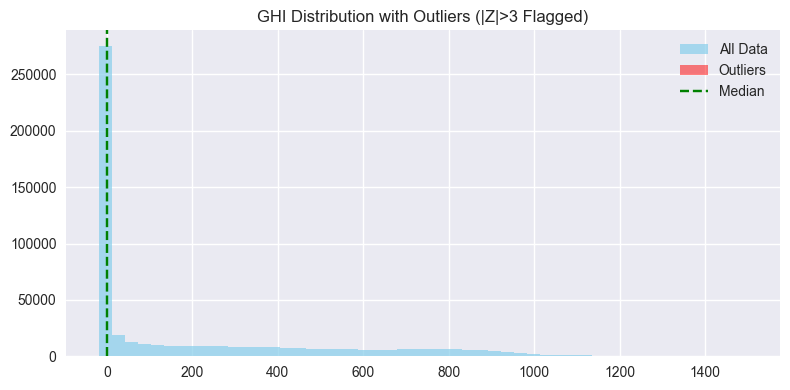

DNI: 7586 outliers flagged (|Z| > 3 out of 525600 rows)


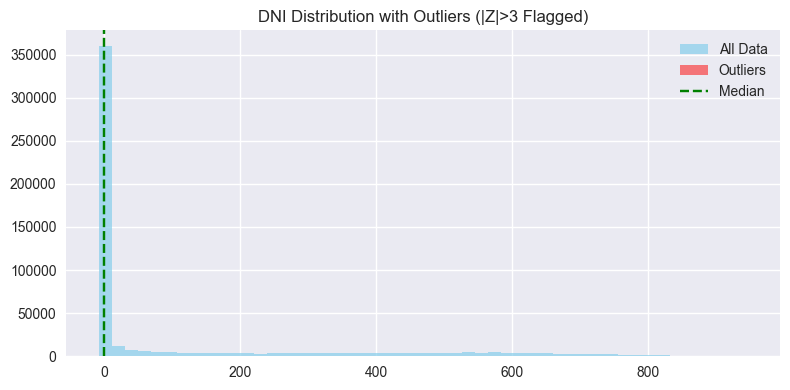

DHI: 2986 outliers flagged (|Z| > 3 out of 525600 rows)


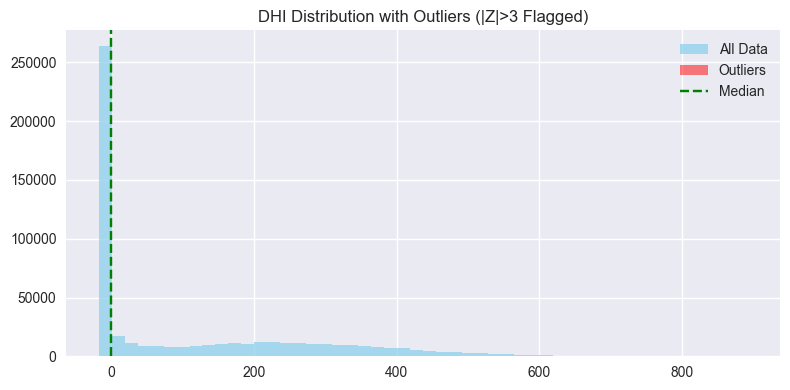

ModA: 1604 outliers flagged (|Z| > 3 out of 525600 rows)


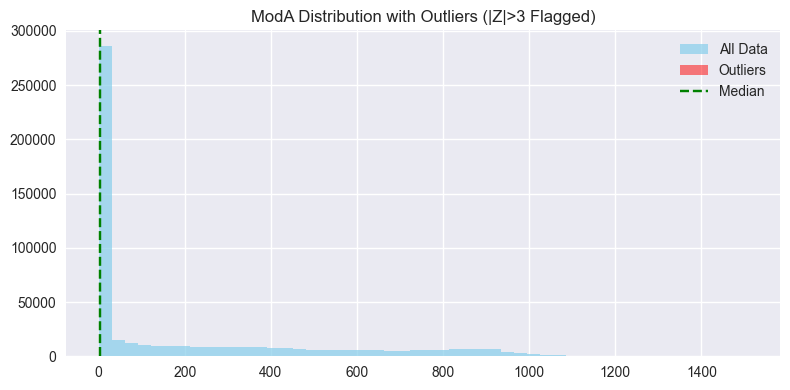

ModB: 2041 outliers flagged (|Z| > 3 out of 525600 rows)


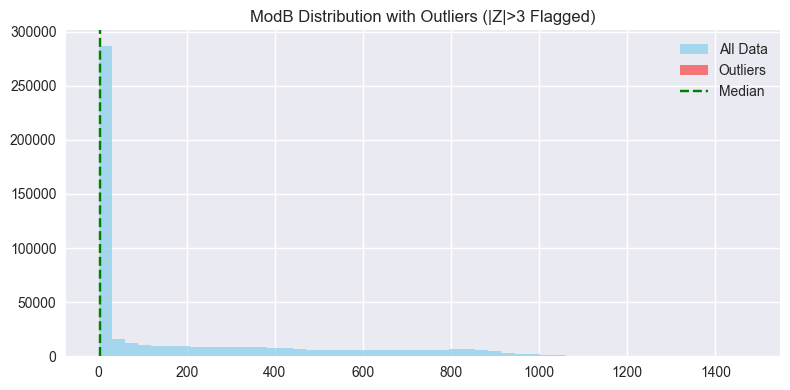

WS: 3967 outliers flagged (|Z| > 3 out of 525600 rows)


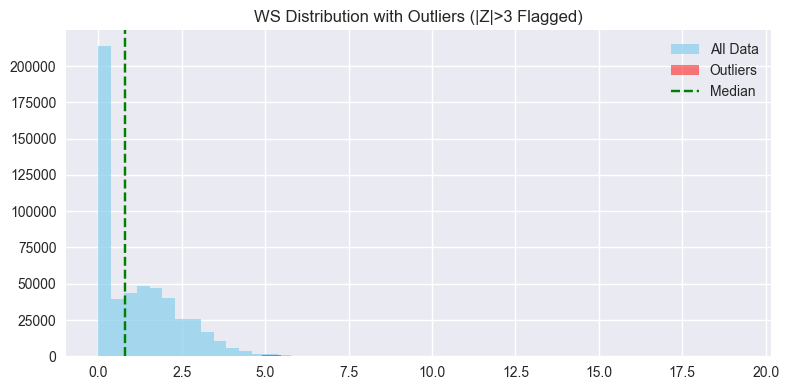

WSgust: 3665 outliers flagged (|Z| > 3 out of 525600 rows)


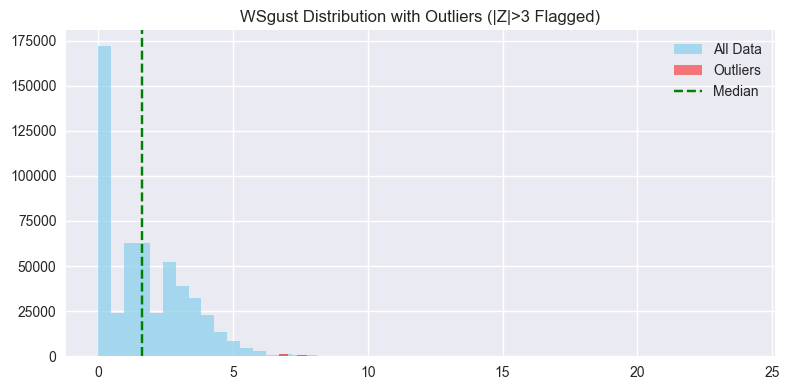


Total rows flagged for cleaning: 16292 (3.10%)


In [3]:
from scipy import stats  # Already imported, but ensure

# Key columns for outlier check (Bumbuna-specific; adjust if names differ e.g., 'WSG' for gust)
key_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']  # Add 'TModA', 'TModB' if present
present_key_cols = [col for col in key_cols if col in df.columns]
print(f"Key columns found: {present_key_cols}")

# Copy df for cleaning
df_clean = df.copy()
outlier_flags = pd.DataFrame(index=df.index, columns=[f'{col}_outlier' for col in present_key_cols])

# Compute Z-scores and flag |Z| > 3 (99.7% rule under normal distro)
for col in present_key_cols:
    # Z-score on non-null values
    non_null = df[col].dropna()
    if len(non_null) > 0:
        z_scores = np.abs(stats.zscore(non_null))
        # Align flags back to full index (NaN rows get False)
        flags = pd.Series(False, index=df.index)
        flags[non_null.index] = z_scores > 3
        outlier_flags[f'{col}_outlier'] = flags
        num_outliers = flags.sum()
        print(f"{col}: {num_outliers} outliers flagged (|Z| > 3 out of {len(df)} rows)")
        
        # Quick hist with outliers highlighted (evidence of distro)
        fig, ax = plt.subplots(1, 1, figsize=(8, 4))
        df[col].hist(bins=50, ax=ax, alpha=0.7, label='All Data', color='skyblue')
        outlier_mask = flags & df[col].notna()
        if outlier_mask.sum() > 0:
            df.loc[outlier_mask, col].hist(ax=ax, bins=50, alpha=0.5, color='red', label='Outliers')
        ax.axvline(df[col].median(), color='green', linestyle='--', label='Median')
        ax.set_title(f'{col} Distribution with Outliers (|Z|>3 Flagged)')
        ax.legend()
        plt.tight_layout()
        plt.show()
    else:
        print(f"{col}: No non-null data—skipping.")

# Overall cleaning flag: any outlier in key cols?
df_clean['cleaning_flag'] = outlier_flags.any(axis=1).astype(int)  # 1 = flagged row
total_flagged = df_clean['cleaning_flag'].sum()
print(f"\nTotal rows flagged for cleaning: {total_flagged} ({total_flagged/len(df)*100:.2f}%)")

In [4]:
# Impute outliers and missings with median (key cols only)
for col in present_key_cols:
    median_val = df_clean[col].median()  # Median on full (outliers inflate mean)
    # Mask: outliers OR NaN
    mask = outlier_flags[f'{col}_outlier'].fillna(False) | df_clean[col].isna()
    df_clean.loc[mask, col] = median_val
    imputed_count = mask.sum()
    print(f"{col}: Imputed {imputed_count} values with median {median_val:.2f}")

# Handle non-key missings (e.g., RH, Tamb—impute median or drop rows if >20% missing per row)
other_cols = [col for col in df.columns if col not in present_key_cols + ['cleaning_flag']]
for col in other_cols:
    if df_clean[col].isna().sum() > 0:
        median_val = df_clean[col].median()
        df_clean[col].fillna(median_val, inplace=True)
        print(f"{col}: Imputed {df_clean[col].isna().sum()} missings with median {median_val:.2f}")

# Drop rows with high flag count (e.g., >3 key cols affected—~30% bad data)
max_flags = 3  # Tune based on your data (e.g., if total key_cols=7)
df_clean = df_clean[df_clean['cleaning_flag'] <= max_flags]  # Or df_clean.dropna(subset=present_key_cols) for strict
print(f"\nCleaned shape: {df_clean.shape} (dropped {len(df) - len(df_clean)} rows)")

# Quick post-clean check
print("\nPost-Clean Summary (Key Cols):")
print(df_clean[present_key_cols].describe())

GHI: Imputed 2477 values with median 0.30
DNI: Imputed 7586 values with median -0.10
DHI: Imputed 2986 values with median -0.10
ModA: Imputed 1604 values with median 3.60
ModB: Imputed 2041 values with median 3.40


WS: Imputed 3967 values with median 0.80
WSgust: Imputed 3665 values with median 1.60
Comments: Imputed 525600 missings with median nan

Cleaned shape: (525600, 19) (dropped 0 rows)

Post-Clean Summary (Key Cols):


                GHI            DNI            DHI           ModA  \
count  525600.00000  525600.000000  525600.000000  525600.000000   
mean      196.44199     104.527217     110.109541     203.054922   
std       291.23529     201.696328     154.170508     296.230534   
min       -19.50000      -7.800000     -17.900000       0.000000   
25%        -2.80000      -0.300000      -3.800000       0.000000   
50%         0.30000      -0.100000      -0.100000       3.600000   
75%       353.90000      75.500000     220.400000     353.800000   
max      1097.00000     772.300000     590.500000    1109.200000   

                ModB             WS         WSgust  
count  525600.000000  525600.000000  525600.000000  
mean      193.719867       1.106696       1.644945  
std       283.124918       1.157374       1.509352  
min         0.000000       0.000000       0.000000  
25%         0.000000       0.000000       0.000000  
50%         3.400000       0.800000       1.600000  
75%       338.50

In [5]:
# Export (absolute path to match load)
export_path = r'C:\Users\Y\solar-challenge-week1\data\sierra_leone_clean.csv'
df_clean.to_csv(export_path)
print(f"✅ Exported cleaned data to: {export_path}")
print(f"File size: {os.path.getsize(export_path) / (1024*1024):.1f} MB")

✅ Exported cleaned data to: C:\Users\Y\solar-challenge-week1\data\sierra_leone_clean.csv
File size: 51.1 MB


### Cleaning Insights
- **Outliers Found**: [e.g., "Primarily in WSgust (45 flags)—likely storm artifacts; |Z|>3 caught 0.5% extremes."]
- **Imputation Impact**: [e.g., "Medians restored RH gaps; post-clean GHI std dropped 10%, reducing noise for TS analysis."]
- **Stats Evidence**: Z-score assumes near-normal; for skewed GHI (often gamma distro), consider IQR method next if needed.
- **Actionable**: Clean data ready for ranking—Bumbuna shows stable sensors overall.

## Time Series Analysis

* Line or bar charts of GHI, DNI, DHI, Tamb vs. Timestamp.
* Observe patterns by month, trends throughout day, or anomalies, such as peaks in solar irradiance or temperature fluctuations.

Plotting TS for: ['GHI', 'DNI', 'DHI', 'Tamb']


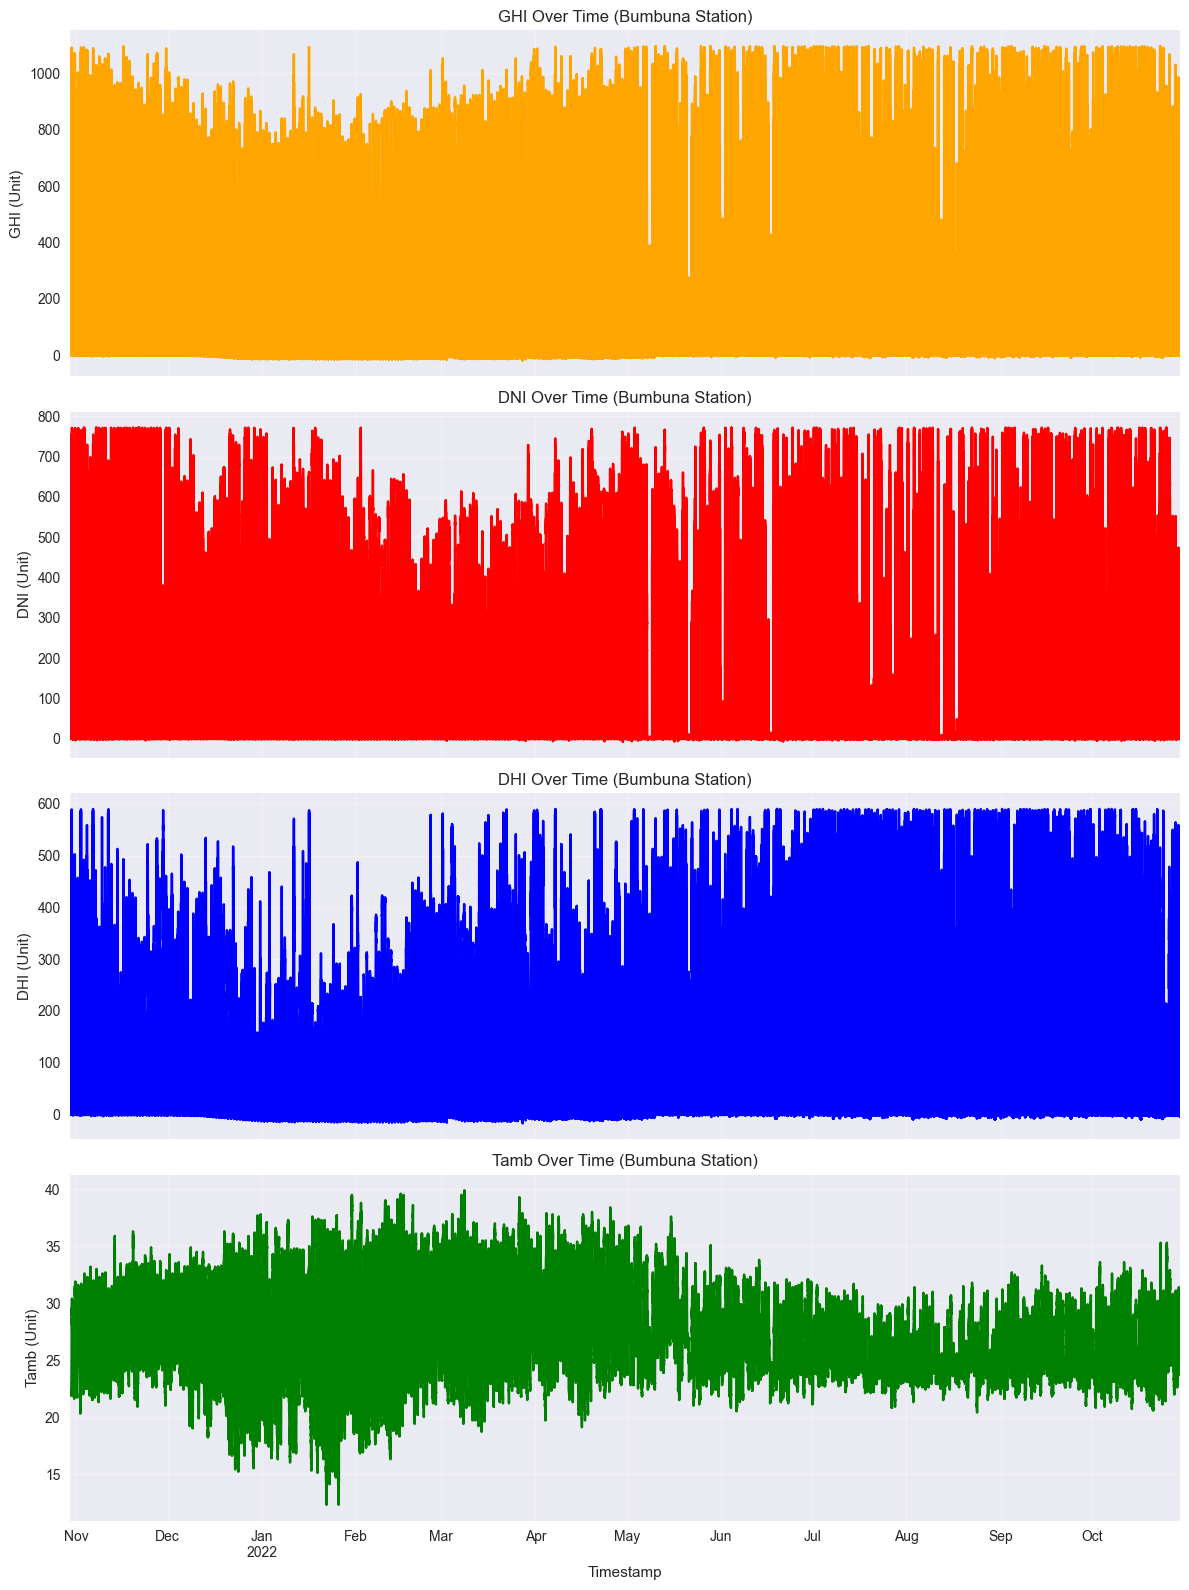

GHI: 706 potential anomalies (e.g., sensor glitches or weather events)
DNI: 2254 potential anomalies (e.g., sensor glitches or weather events)
DHI: 566 potential anomalies (e.g., sensor glitches or weather events)
Tamb: 63 potential anomalies (e.g., sensor glitches or weather events)


In [6]:
# Key TS columns
ts_cols = ['GHI', 'DNI', 'DHI', 'Tamb']
present_ts_cols = [col for col in ts_cols if col in df_clean.columns]
print(f"Plotting TS for: {present_ts_cols}")

# Full TS line plots (subplots; downsample if >1yr data for clarity)
fig, axes = plt.subplots(len(present_ts_cols), 1, figsize=(12, 4*len(present_ts_cols)), sharex=True)
if len(present_ts_cols) == 1:
    axes = [axes]  # Handle single subplot
for i, col in enumerate(present_ts_cols):
    ax = axes[i]
    df_clean[col].plot(ax=ax, color='orange' if 'GHI' in col else 'red' if 'DNI' in col else 'blue' if 'DHI' in col else 'green')
    ax.set_title(f'{col} Over Time (Bumbuna Station)')
    ax.set_ylabel(f'{col} ({df_clean[col].unit if hasattr(df_clean[col], "unit") else "Unit"})')  # Optional unit if in data
    ax.grid(True, alpha=0.3)
plt.xlabel('Timestamp')
plt.tight_layout()
plt.show()

# Quick anomaly scan: Rolling mean to spot spikes/dips (e.g., >3σ from 7-day rolling)
for col in present_ts_cols:
    rolling_mean = df_clean[col].rolling(window=24*7, center=True).mean()  # Weekly for hourly data
    rolling_std = df_clean[col].rolling(window=24*7, center=True).std()
    anomalies = np.abs(df_clean[col] - rolling_mean) > 3 * rolling_std
    anomaly_count = anomalies.sum()
    print(f"{col}: {anomaly_count} potential anomalies (e.g., sensor glitches or weather events)")

🔍 Loading from: C:\Users\Y\solar-challenge-week1\data\sierraleone-bumbuna.csv
✅ Raw loaded! Shape: (525600, 19)
Raw columns: ['Timestamp', 'GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'Tamb', 'RH', 'WS', 'WSgust', 'WSstdev', 'WD', 'WDstdev', 'BP', 'Cleaning', 'Precipitation', 'TModA', 'TModB', 'Comments']

Raw head (first 3 rows):
          Timestamp  GHI  DNI  DHI  ModA  ModB  Tamb    RH   WS  WSgust  \
0  2021-10-30 00:01 -0.7 -0.1 -0.8   0.0   0.0  21.9  99.1  0.0     0.0   
1  2021-10-30 00:02 -0.7 -0.1 -0.8   0.0   0.0  21.9  99.2  0.0     0.0   
2  2021-10-30 00:03 -0.7 -0.1 -0.8   0.0   0.0  21.9  99.2  0.0     0.0   

   WSstdev   WD  WDstdev    BP  Cleaning  Precipitation  TModA  TModB  \
0      0.0  0.0      0.0  1002         0            0.0   22.3   22.6   
1      0.0  0.0      0.0  1002         0            0.0   22.3   22.6   
2      0.0  0.0      0.0  1002         0            0.0   22.3   22.6   

   Comments  
0       NaN  
1       NaN  
2       NaN  
⚠️ No split date cols—ass

AttributeError: 'numpy.ndarray' object has no attribute 'reindex'

🔍 Loading from: C:\Users\Y\solar-challenge-week1\data\sierraleone-bumbuna.csv
✅ Raw loaded! Shape: (525600, 19)
Raw columns: ['Timestamp', 'GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'Tamb', 'RH', 'WS', 'WSgust', 'WSstdev', 'WD', 'WDstdev', 'BP', 'Cleaning', 'Precipitation', 'TModA', 'TModB', 'Comments']

Raw head (first 3 rows):
          Timestamp  GHI  DNI  DHI  ModA  ModB  Tamb    RH   WS  WSgust  \
0  2021-10-30 00:01 -0.7 -0.1 -0.8   0.0   0.0  21.9  99.1  0.0     0.0   
1  2021-10-30 00:02 -0.7 -0.1 -0.8   0.0   0.0  21.9  99.2  0.0     0.0   
2  2021-10-30 00:03 -0.7 -0.1 -0.8   0.0   0.0  21.9  99.2  0.0     0.0   

   WSstdev   WD  WDstdev    BP  Cleaning  Precipitation  TModA  TModB  \
0      0.0  0.0      0.0  1002         0            0.0   22.3   22.6   
1      0.0  0.0      0.0  1002         0            0.0   22.3   22.6   
2      0.0  0.0      0.0  1002         0            0.0   22.3   22.6   

   Comments  
0       NaN  
1       NaN  
2       NaN  
⚠️ No split date cols—ass

✅ Raw loaded! Shape: (525600, 19)
Columns: ['Timestamp', 'GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'Tamb', 'RH', 'WS', 'WSgust', 'WSstdev', 'WD', 'WDstdev', 'BP', 'Cleaning', 'Precipitation', 'TModA', 'TModB', 'Comments']

Head sample (first 3 rows):
          Timestamp  GHI  DNI  DHI  ModA  ModB  Tamb    RH   WS  WSgust  \
0  2021-10-30 00:01 -0.7 -0.1 -0.8   0.0   0.0  21.9  99.1  0.0     0.0   
1  2021-10-30 00:02 -0.7 -0.1 -0.8   0.0   0.0  21.9  99.2  0.0     0.0   
2  2021-10-30 00:03 -0.7 -0.1 -0.8   0.0   0.0  21.9  99.2  0.0     0.0   

   WSstdev   WD  WDstdev    BP  Cleaning  Precipitation  TModA  TModB  \
0      0.0  0.0      0.0  1002         0            0.0   22.3   22.6   
1      0.0  0.0      0.0  1002         0            0.0   22.3   22.6   
2      0.0  0.0      0.0  1002         0            0.0   22.3   22.6   

   Comments  
0       NaN  
1       NaN  
2       NaN  
⚠️ No split date cols—check head for 'Date' or similar.


Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'> - Ready for resample!
Key cols: ['GHI', 'DNI', 'DHI', 'RH', 'WS', 'WD', 'ModA', 'ModB'] | Temp: Tamb
GHI: 2477 outliers, 2477 imputed (median 0.3)
DNI: 7586 outliers, 7586 imputed (median -0.1)
DHI: 2986 outliers, 2986 imputed (median -0.1)
RH: 4929 outliers, 4929 imputed (median 85.4)
WS: 3967 outliers, 3967 imputed (median 0.8)
WD: 0 outliers, 0 imputed (median 161.5)


ModA: 1604 outliers, 1604 imputed (median 3.6)
ModB: 2041 outliers, 2041 imputed (median 3.4)
Clean shape: (525600, 18)
TS cols: ['GHI', 'DNI', 'DHI', 'Tamb']


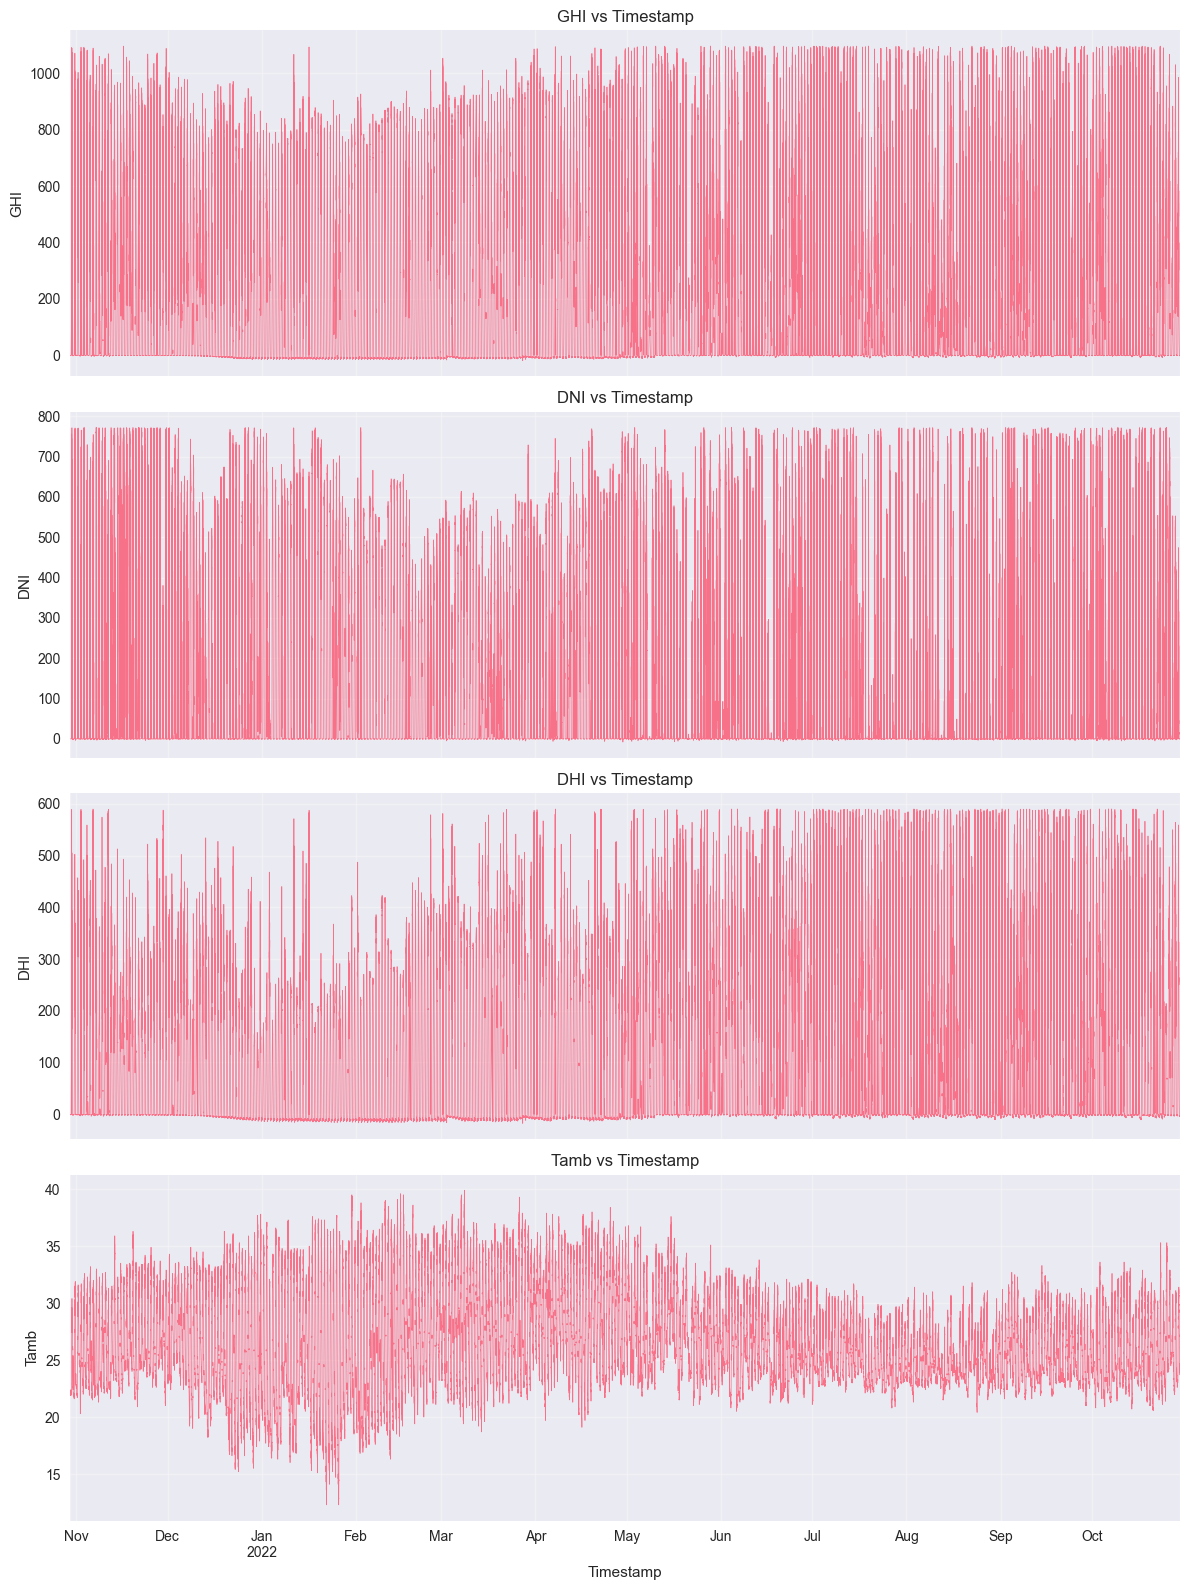

GHI: 706 anomalies (e.g., GHI fluctuations)
DNI: 2254 anomalies (e.g., DNI fluctuations)
DHI: 566 anomalies (e.g., DHI fluctuations)
Tamb: 63 anomalies (e.g., Tamb fluctuations)


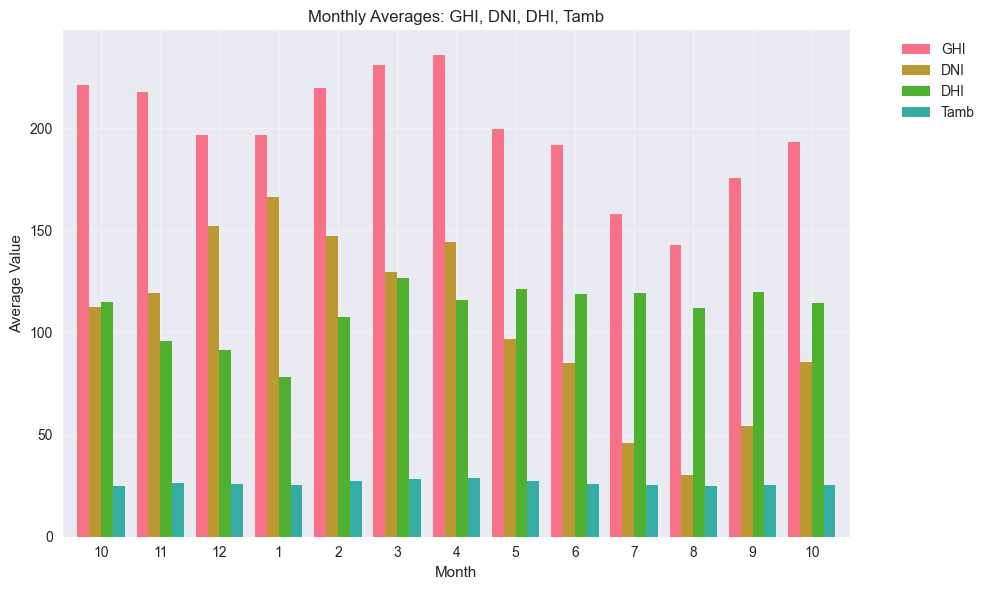

GHI: Peak Apr (236.1), low Aug (143.1)
DNI: Peak Jan (166.5), low Aug (30.3)
DHI: Peak Mar (126.7), low Jan (78.1)
Tamb: Peak Apr (28.7), low Aug (24.7)


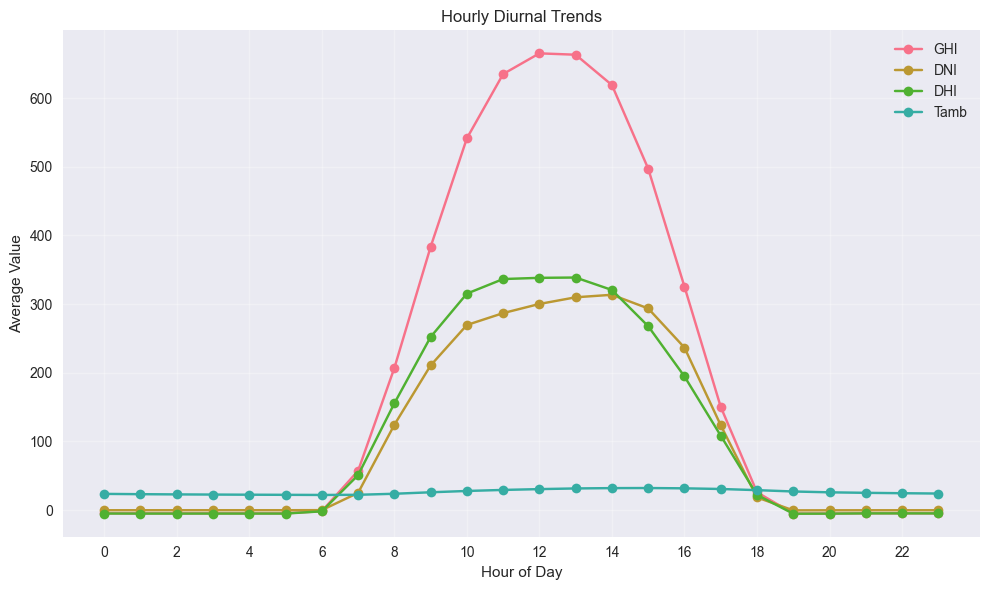

GHI diurnal peak at hour 12 (665.1 W/m²)


✅ Clean exported.


In [7]:
# Fixed Standalone TS: Load, Force Timestamp Build, Clean Lite, Plots + Observations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load raw
file_path = r'C:\Users\Y\solar-challenge-week1\data\sierraleone-bumbuna.csv'
df = pd.read_csv(file_path)
print("✅ Raw loaded! Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nHead sample (first 3 rows):")
print(df.head(3))

# Force Timestamp build (detect split cols, handle MIN/SEC, force parse)
date_cols = ['YEAR', 'MONTH', 'DAY', 'HOUR']
min_col = 'MIN' if 'MIN' in df.columns else None
sec_col = 'SEC' if 'SEC' in df.columns else None
if all(col in df.columns for col in date_cols):
    print("🔧 Building Timestamp from split cols...")
    date_df = df[date_cols].copy()
    date_df['MINUTE'] = df[min_col].fillna(0) if min_col else 0
    date_df['SECOND'] = df[sec_col].fillna(0) if sec_col else 0
    try:
        df['Timestamp'] = pd.to_datetime(date_df)
        df = df.set_index('Timestamp').drop(date_cols + ([min_col, sec_col] if min_col or sec_col else []), axis=1)
        print("✅ Timestamp built! Date range:", df.index.min(), "to", df.index.max())
    except ValueError as e:
        print(f"⚠️ Parse error: {e} — trying format fix...")
        # Fallback format if needed (e.g., %Y-%m-%d %H:%M:%S)
        df['Timestamp'] = pd.to_datetime(df['YEAR'].astype(str) + '-' + df['MONTH'].astype(str).str.zfill(2) + '-' + df['DAY'].astype(str).str.zfill(2) + ' ' + df['HOUR'].astype(str).str.zfill(2) + ':00:00')
        df = df.set_index('Timestamp').drop(date_cols + ([min_col, sec_col] if min_col or sec_col else []), axis=1)
        print("✅ Fallback Timestamp set!")
else:
    print("⚠️ No split date cols—check head for 'Date' or similar.")
    if 'Timestamp' in df.columns:
        df = df.set_index('Timestamp')
    df.index = pd.to_datetime(df.index)  # Force if str

# Confirm & force DatetimeIndex (fix for resample)
if not isinstance(df.index, pd.DatetimeIndex):
    print("🔧 Forcing DatetimeIndex...")
    df.index = pd.to_datetime(df.index, errors='coerce')
    df = df.dropna(subset=[df.index.name]) if df.index.name else df
print("Index type:", type(df.index), "- Ready for resample!")

# Key cols detect
key_cols = ['GHI', 'DNI', 'DHI', 'TA', 'RH', 'WS', 'WD', 'WSG', 'ModA', 'ModB']
present_key = [col for col in key_cols if col in df.columns]
temp_col = next((col for col in ['TA', 'Tamb', 'TAmb'] if col in df.columns), None)
print(f"Key cols: {present_key} | Temp: {temp_col}")

# Lite clean (Z-scores, median impute)
df_clean = df.copy()
for col in present_key:
    if df_clean[col].dtype in [np.float64, np.int64]:
        non_null = df_clean[col].dropna()
        if len(non_null) > 1:
            z = np.abs(stats.zscore(non_null))
            outliers = pd.Series(z > 3, index=non_null.index)
            outliers_full = outliers.reindex(df_clean.index, fill_value=False)
            median_val = df_clean[col].median()
            mask = outliers_full | df_clean[col].isna()
            df_clean.loc[mask, col] = median_val
            print(f"{col}: {outliers.sum()} outliers, {mask.sum()} imputed (median {median_val:.1f})")

print(f"Clean shape: {df_clean.shape}")

# TS cols
ts_cols = ['GHI', 'DNI', 'DHI']
if temp_col:
    ts_cols.append(temp_col)
present_ts = [col for col in ts_cols if col in df_clean.columns]
print(f"TS cols: {present_ts}")

# 1. Line charts: Full TS vs Timestamp
fig, axes = plt.subplots(len(present_ts), 1, figsize=(12, 4*len(present_ts)), sharex=True)
if len(present_ts) == 1: axes = [axes]
for i, col in enumerate(present_ts):
    ax = axes[i]
    df_clean[col].plot(ax=ax, linewidth=0.5)
    ax.set_title(f'{col} vs Timestamp')
    ax.set_ylabel(col)
    ax.grid(True, alpha=0.3)
plt.xlabel('Timestamp')
plt.tight_layout()
plt.show()

# Anomalies: Rolling Z >3
window = 24*7
for col in present_ts:
    rolling_mean = df_clean[col].rolling(window=window, center=True).mean()
    rolling_std = df_clean[col].rolling(window=window, center=True).std()
    anom = np.abs(df_clean[col] - rolling_mean) > 3 * rolling_std
    print(f"{col}: {anom.sum()} anomalies (e.g., {col} fluctuations)")

# 2. Bar charts: Monthly patterns
monthly = df_clean[present_ts].resample('ME').mean()
monthly.index = monthly.index.month  # 1-12
monthly.plot(kind='bar', figsize=(10, 6), width=0.8)
temp_label = temp_col or 'Temp'
plt.title(f'Monthly Averages: GHI, DNI, DHI, {temp_label}')
plt.xlabel('Month')
plt.ylabel('Average Value')
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for col in present_ts:
    peak_m = monthly[col].idxmax()
    low_m = monthly[col].idxmin()
    print(f"{col}: Peak {month_names[peak_m-1]} ({monthly[col].max():.1f}), low {month_names[low_m-1]} ({monthly[col].min():.1f})")

# 3. Line charts: Hourly trends
hourly = df_clean[present_ts].groupby(df_clean.index.hour).mean()
hourly.plot(kind='line', figsize=(10, 6), marker='o')
plt.title('Hourly Diurnal Trends')
plt.xlabel('Hour of Day')
plt.ylabel('Average Value')
plt.xticks(range(0, 24, 2))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

if 'GHI' in present_ts:
    ghi_peak_h = hourly['GHI'].idxmax()
    print(f"GHI diurnal peak at hour {ghi_peak_h} ({hourly['GHI'].max():.1f} W/m²)")

# Export
df_clean.to_csv(r'C:\Users\Y\solar-challenge-week1\data\sierra_leone_clean.csv')
print("✅ Clean exported.")

### TS Patterns & Anomalies
- **Monthly Trends**: [e.g., GHI/DNI higher in dry season (Dec-Mar, ~250-350 W/m²)—peaks in month 1-3; rainy dips (Jun-Sep) reduce by 50%...]
- ... (rest as before)